# Convert OpenSN data to name,host,type,x,y,z,t

Data downloaded from The Open Supernova Catalog https://sne.space on Dec. 2, 2019

In [0]:
import pandas as pd
import numpy as np
from astropy import units
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import WMAP9
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
df = pd.read_csv('The Open Supernova Catalog.csv')
# Select SNe that have position and time data (Switched from 'dL (Mpc)' to 'z' for proper scaling of distance)
# 37372 including NaN distance, otherwise 19204 SNe
# must have dL (Mpc) or z value
df = df.loc[(df['R.A.'].notnull()) & \
              (df['Dec.'].notnull()) & \
              (df['dL (Mpc)'].notnull()) & \
              (df['Type'].notnull()) & \
              (df['Disc. Date'].notnull())]
print(len(df))
df

19392


,Name,Disc. Date,Mmax,Host Name,R.A.,Dec.,z,dL (Mpc),Type
0,SN2011fe,2011/08/24,-18.280,M101,"14:03:05.711,14:03:05.76,14:03:05.81,14:03:05.80","+54:16:25.22,+54:16:25.32,+54:16:25.4,+54:16:25.3",0.000804,3.5600,Ia
1,SN1987A,1987/02/24,-16.300,LMC,"05:35:28.020,05:35:28,05:35:28.01,05:35:27.989...","-69:16:11.07,-69:16:11,-69:16:11.61,-69:16:11....","9.51e-06,9.78e-06,1.02e-05,1.06e-05,1.07e-05,1...",0.0430,II Pec
2,SN2003dh,2003/03/31,-26.823,A104450+2131,"10:44:50.030,10:44:50.01,10:44:50.018","+21:31:18.15,+21:31:17.8,+21:31:17.89",0.1685,836.4300,Ic BL
3,SN2013dy,2013/07/10,-18.381,NGC 7250,22:18:17.60,+40:34:09.6,0.003889,17.2630,Ia
4,SN2013ej,2013/07/25,-18.380,NGC 628,01:36:48.16,+15:45:31.0,0.002192,9.5700,II-P/L
...,...,...,...,...,...,...,...,...,...
51573,SN2018fip,2018/07/28,NaN,NaN,16:54:15.750,-54:02:39.27,0.117,562.4000,Ic BL
55459,SN185A,185/12/07,-16.000,Milky Way,"14:43:00,14:35:55,14:43:30.000","-62:30,-60:36,-62:28:00.00",NaN,0.0025,Ia
55462,SN1954J,1954/11/26,NaN,NGC 2403,"07:36:56.20,07:36:55.361,07:36:55.36","+65:37:52.3,+65:37:52.10,+65:37:52.1",0.00043,1.9000,II Pec?
55465,SN1988M,1988/04/07,NaN,NGC 4496B,"12:31:40.9,12:31:41.04,12:31:40.900,12:31:40.93","+03:55:23,+03:55:23.16,+03:55:21.00,+03:55:21....","0.01511,0.015",13.0000,II


I will have to iterate through the rows, since some coords have multiple entries, and some dates are bad

In [22]:
countII = 0
countIa = 0
countI = 0
countC = 0
countOther = 0
for index, row in df.iterrows():
    if "II" in row["Type"]:
      countII = countII + 1
    elif "Ia" in row["Type"]:
      countIa = countIa + 1
    elif "I" in row["Type"]:
      countI = countI + 1
    elif "Candidate" in row["Type"]:
      countC = countC + 1
    else:
      countOther = countOther + 1
print("II: ", countII)
print("Ia: " , countIa)
print("I: " , countI)
print("Candidate: " , countC)
print("Other: " , countOther)


II:  3985
Ia:  11887
I:  1166
Candidate:  1950
Other:  404


In [23]:
# check dL (Mpc) and z values and conversion values
for index, row in df.iterrows():
  print("dL (Mpc) | z | Mpc -> z : " + str(row['dL (Mpc)']) + " | " + str(row['z']) + " | " + str(Distance(row['dL (Mpc)']*units.Mpc).z))

dL (Mpc) | z | Mpc -> z : 3.56 | 0.000804 | 0.000822635710015015
dL (Mpc) | z | Mpc -> z : 0.043 | 9.51e-06,9.78e-06,1.02e-05,1.06e-05,1.07e-05,1.11e-05,1.12e-05,1.13e-05,1.14e-05,1.15e-05,1.16e-05,1.17e-05,1.19e-05,1.22e-05 | 9.942670823488428e-06
dL (Mpc) | z | Mpc -> z : 836.43 | 0.1685 | 0.17161761729071487
dL (Mpc) | z | Mpc -> z : 17.262999999999998 | 0.003889 | 0.003979251470445287
dL (Mpc) | z | Mpc -> z : 9.57 | 0.002192 | 0.0022090109371099833
dL (Mpc) | z | Mpc -> z : 156.2 | 0.0344 | 0.03515873414180242
dL (Mpc) | z | Mpc -> z : 2.9 | -0.000113 | 0.0006702046769196492
dL (Mpc) | z | Mpc -> z : 24.0 | 0.0054 | 0.0055255157593537135
dL (Mpc) | z | Mpc -> z : 9.3443 | 0.002108 | 0.0021570011589067354
dL (Mpc) | z | Mpc -> z : 11.507 | 0.002595 | 0.002655195224172272
dL (Mpc) | z | Mpc -> z : 26.426 | 0.005944 | 0.006081421118832271
dL (Mpc) | z | Mpc -> z : 2.998 | 0.000677,0.000739,0.000841 | 0.0006928407120298818
dL (Mpc) | z | Mpc -> z : 7.2583 | 0.001638 | 0.00167610804184

In [24]:
x = []
y = []
z = []
t = []

log10lum = []
name = []
host = []
tpe = []

#for datetime
fmt = '%Y/%m/%d'

N = 1e10
for index, row in df.iterrows():
    bad = False
    badType = False
    badZ = False

    #there are still some dates that cause errors (e.g., 185/12/07/)
    date = str(row['Disc. Date'])
    pos = date.find(',')
    fmt0 = fmt
    if (pos != -1):    
        date = row['Disc. Date'][0:pos]
    pos1 = date.find('/')
    pos2 = date.rfind('/')
    if (pos1 == -1):
        fmt0 = '%Y'
    if (pos1 != -1 and pos2 == pos1):
        fmt0 = '%Y/%m'
    if (fmt0 == fmt):
        val1 = int(date[0:pos1])
        if (val1 <= 12):
            fmt0 = '%m/%d/%Y'
        if (val1 > 12 and val1 < 1800):
            bad = True
    # Check for type and enter clean version
    if "I" not in row["Type"]:
      badType = True

    if (not bad) and (not badType) and (not badZ):
        if "II" in row["Type"]:
          tpe.append("II")
        elif "Ia" in row["Type"]:
          tpe.append("Ia")
        elif "I" in row["Type"]:
          tpe.append("I")
        else:
          print("error?..." + row["Type"])
          tpe.append(row["Type"])
        
        dt = datetime.datetime.strptime(date, fmt0) 
        t.append(dt.year + dt.month/12. + dt.day/365.24)
        
        ra = row['R.A.']
        pos = str(ra).find(',')
        if (pos != -1):    
            ra = row['R.A.'][0:pos]

        dec = row['Dec.']
        pos = str(dec).find(',')
        if (pos != -1):    
            dec = row['Dec.'][0:pos]
        # Convert dL (Mpc) to z
        d = Distance(row['dL (Mpc)']*units.Mpc).z
        
        # Convert z to  comoving_distance
        c1 = SkyCoord(ra, dec, unit=(units.hourangle, units.deg), distance=WMAP9.comoving_distance(d)).galactic.cartesian
        x.append(c1.x.to(units.Mpc).value)
        y.append(c1.y.to(units.Mpc).value)
        z.append(c1.z.to(units.Mpc).value)

        log10lum.append(0.4*(4.74 - row['Mmax']))

        name.append(row['Name'])
        host.append(row['Host Name'])
        
        
    if (index > N):
        break

print("done")

done


1885.7132114043734 2019.9933285875954
['Ia', 'II', 'I', 'Ia', 'II', 'II', 'II', 'Ia', 'I', 'II', 'II', 'Ia', 'II', 'Ia', 'Ia', 'Ia', 'II', 'Ia', 'Ia', 'Ia', 'II', 'Ia', 'II', 'II', 'I', 'II', 'II', 'Ia', 'Ia', 'II', 'Ia', 'I', 'Ia', 'Ia', 'II', 'I', 'Ia', 'II', 'Ia', 'II', 'I', 'Ia', 'Ia', 'Ia', 'I', 'Ia', 'Ia', 'I', 'II', 'II', 'II', 'Ia', 'I', 'Ia', 'Ia', 'II', 'Ia', 'II', 'Ia', 'Ia', 'Ia', 'II', 'Ia', 'Ia', 'Ia', 'II', 'Ia', 'II', 'Ia', 'I', 'Ia', 'I', 'Ia', 'I', 'Ia', 'Ia', 'Ia', 'II', 'II', 'Ia', 'Ia', 'II', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'II', 'Ia', 'II', 'Ia', 'Ia', 'II', 'II', 'I', 'Ia', 'II', 'I', 'II', 'II', 'Ia', 'I', 'Ia', 'Ia', 'Ia', 'I', 'Ia', 'Ia', 'I', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'I', 'Ia', 'II', 'II', 'Ia', 'Ia', 'II', 'Ia', 'I', 'Ia', 'II', 'I', 'II', 'II', 'I', 'I', 'II', 'II', 'I', 'Ia', 'Ia', 'I', 'Ia', 'II', 'Ia', 'Ia', 'Ia', 'Ia', 'II', 'Ia', 'Ia', 'II', 'I', 'II', 'II', 'Ia', 'I', 'Ia', 'Ia', 'Ia', 'Ia', 'II', 'II', 'Ia', 'II', 'II', 'I', 'I', 'II', 'I', 'Ia', 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


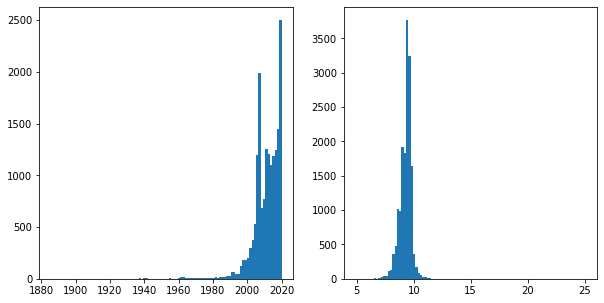

In [25]:
print(min(t), max(t))
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
_ = ax1.hist(t,bins=100)
_ = ax2.hist(log10lum,bins=100)
print(tpe)
distances = np.sqrt(np.array(x)**2. + np.array(y)**2. + np.array(z)**2.)
print(max(x))
print(max(y))
print(max(z))
print(max(distances))

### Write this to a new csv file

In [26]:
print(len(name), len(host), len(tpe), len(x), len(y), len(z), len(t))
data = {'name':np.array(name),
        'host':np.array(host),
        'type':np.array(tpe),
        'x':np.array(x),
        'y':np.array(y),
        'z':np.array(z),
        't':np.array(t),
        'log10lum':np.array(log10lum)}
pd.DataFrame(data).to_csv('OpenSNCatConverted.csv', index=False)

17034 17034 17034 17034 17034 17034 17034
